In [10]:
import torch, random, os
import hiddenlayer as hl
from model.vgg import Backend
from model.CPR import CPRmodel
from model.paf_model import PAFModel
import torch.nn as nn
import numpy as np
import json, cv2
import torchvision.models as models
from data_process.data_loader_provider import create_data_loaders
from model.model_provider import create_model, create_optimizer
from training.train_net import process

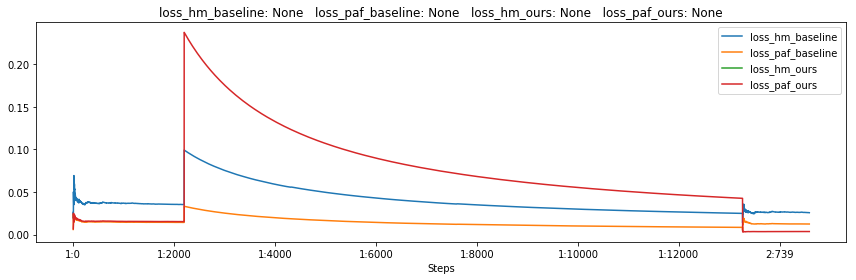

In [11]:
his = hl.History()
his2 = hl.History()
his.load("../exp/4-8_baseline/experiment.pkl")
his2.load("../exp/4-8/experiment.pkl")
canvas = hl.Canvas()
for i in range(len(his2.steps)):
    his.log(his.steps[i], 
            loss_hm_baseline=his["loss_hm"].data[i],
           loss_paf_baseline=his["loss_paf"].data[i],
           los_hm_ours=his2["loss_hm"].data[i],
           loss_paf_ours=his2["loss_paf"].data[i])
canvas.draw_plot([his["loss_hm_baseline"], his["loss_paf_baseline"],
                 his["loss_hm_ours"], his["loss_paf_ours"]])

IndexError: index -1 is out of bounds for axis 0 with size 0

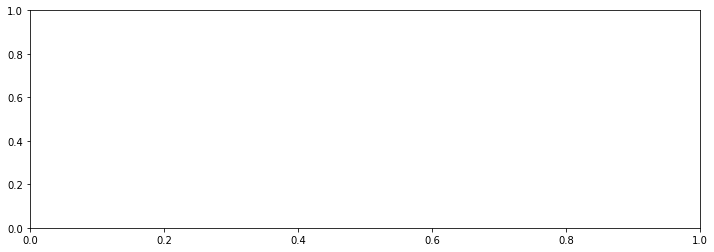

In [9]:
canvas.draw_plot([his["loss_hm_baseline"], his["loss_paf_baseline"]])

In [ ]:
def load_config(json_path):
    with open(json_path, 'rb') as f:
        config = json.loads(f.read())
        config["env"]["saveDir"] = os.path.join(config["env"]["expDir"], config["env"]["expID"])
        if not os.path.exists(config["env"]["saveDir"]):
            os.makedirs(config["env"]["saveDir"])
        return config

In [ ]:

def parse_criterion(criterion):
    if criterion == 'l1':
        return nn.L1Loss(size_average = False)
    elif criterion == 'mse':
        return nn.MSELoss(size_average = False)
    elif criterion == 'smoooth_l1':
        return nn.SmoothL1Loss(size_average=False)
    else:
        raise ValueError('Criterion ' + criterion + ' not supported')


In [ ]:
def create_model(opt):
    if opt["model"]["backend"] == "vgg":
        backend = Backend(models.vgg19, use_bn=True, config=opt["model"][opt["model"]["backend"]])
        backend_feats = 128
    elif opt["model"]["backend"] == "resnet":
        backend = Backend(models.resnet101, use_bn=True, config=opt["model"][opt["model"]["backend"]])
    else:
        raise ValueError('Model ' + opt["model"]["backend"] + ' not available.')
    model = PAFModel(backend, backend_feats, n_joints=18, n_paf=32, n_stages=7) if opt["typ"] == 'paf' else \
                CPRmodel(backend, config=opt)
    criterion_hm = parse_criterion(opt["train"]["criterionHm"])
    criterion_paf = parse_criterion(opt["train"]["criterionPaf"])
    return model, criterion_hm, criterion_paf


In [ ]:
opt = load_config("../exp/4-1/stage_weight.json")

In [ ]:
transforms = [
        hl.transforms.Fold("BatchNorm > Relu > Conv", "BnReluConv"),
        #hl.transforms.Fold("Conv > BatchNorm", "ConvBn"),
        hl.transforms.Fold("BnReluConv > BnReluConv > BnReluConv > Add", "BottleneckBlock", "Bottleneck Block"),
        hl.transforms.Fold("ConvRelu > MaxPool", "ConvReluPool"),
        hl.transforms.Fold("""ConvRelu > ConvReluPool > ConvRelu > ConvReluPool > 
        ConvRelu > ConvRelu > ConvRelu > ConvReluPool > ConvRelu > ConvRelu > ConvBnRelu > ConvBnRelu""", "VGG", "Backend"),
        hl.transforms.FoldDuplicates()
    ]

In [ ]:
cpr_model = hl.build_graph(model, torch.zeros([1, 3, 384, 384]), transforms=[])

In [ ]:
opt["typ"] = "paf"
model, criterion_hm, criterion_paf = create_model(opt)
paf_model = hl.build_graph(model, torch.zeros([1, 3, 384, 384]), transforms=transforms)

In [ ]:
cpr_model

In [ ]:
paf_model

In [ ]:
cpr_model.save(os.path.join(opt["env"]["saveDir"], "gra"))

In [ ]:
model, criterion_hm, criterion_paf = create_model(opt)

In [ ]:
model.stages[-1].block1[-1]

In [ ]:
opt_no_hg=load_config("../exp/3-27/hgs.json")
model_no_hg, criterion_hm, criterion_paf = create_model(opt_no_hg)

In [ ]:
# Seed all sources of randomness to 0 for reproducibility
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
random.seed(0)

print("Using GPU: {}".format(opt["env"]["device"]))

# Create data loaders
# Create data loaders
train_loader, test_loader = create_data_loaders(opt)
# Create nn
model = torch.nn.DataParallel(model, device_ids=[int(index) for index in opt["env"]["device"].split(",")]).cuda() \
        if "," in opt["env"]["device"] else model.cuda()
criterion_hm = criterion_hm.cuda()
criterion_paf = criterion_paf.cuda()

# Create optimizer
optimizer = create_optimizer(opt, model)

# Other params
to_train = opt["to_train"]
visualize_out = opt["viz"]["vizOut"]

# train/ test
Processer = process(model)
if to_train:
    Processer.train_net(train_loader, test_loader, criterion_hm, criterion_paf, optimizer, opt, viz_output=visualize_out)
else:
    Processer.validate_net(test_loader, criterion_hm, criterion_paf, save_dir=opt["env"]["saveDir"], viz_output=visualize_out)

In [ ]:
torch.save(model.state_dict(), os.path.join("../exp/3-27/", 'model_4.pth'))

In [ ]:
opt["env"]["saveDir"]

In [ ]:
from torchvision import models

In [ ]:
resnet = models.resnet34(pretrained=False)
resnet = nn.Sequential(*list(resnet.children())[:6])

In [ ]:
resnet.children

In [ ]:
resnet34_graph = hl.build_graph(resnet, torch.zeros([1, 3, 384, 384]), transforms=[])

In [ ]:
resnet34_graph

In [ ]:
train_loader, test_loader = create_data_loaders(opt)

In [ ]:
his_log = hl.History()

In [ ]:
his_log.load("../exp/4-2/experiment.pkl")

In [ ]:
canvas = hl.Canvas()

In [ ]:
canvas.draw_plot(his_log["loss"])